Búsqueda exhaustiva, Monte Carlo y gradiente descendente
===

* 30:00 min | Última modificación: Mayo 21, 2021 | [YouTube]

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np

## Definición del problema

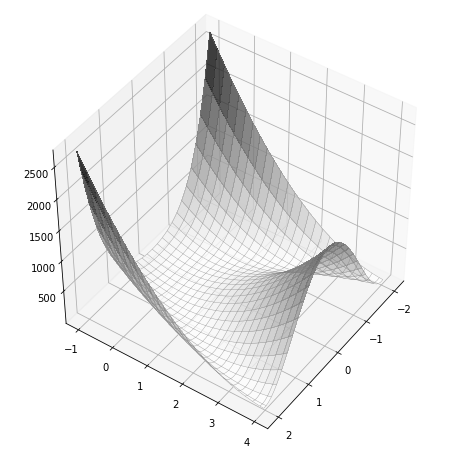

In [2]:
from plots import plot_contour, plot_surface
from testfunctions import rosenbrock as fn

#
# Se desea encontrar el punto de mínima de la función de
# Rosenbrock de dos dimensiones. El punto de mínima es
# f(1, 1) = 0. La región de busqueda es
#
#    -2.048 < x < 2.048
#       -1. < y < 4.
#
plot_surface(
    fn,
    x_bounds=[(-2.048, 2.048), (-1, 4)],
)

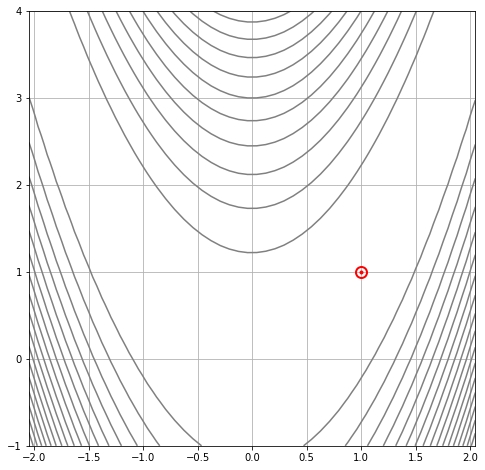

In [3]:
plot_contour(
    fn,
    x_bounds=[(-2.048, 2.048), (-1, 4)],
    minimum=[(1, 1)],
)

## Búsqueda exhaustiva

In [4]:
#
# Este método consiste en generar una malla de puntos.
# El punto de mínima corresponde al menor valor
# encontrado dentro de la malla.
#

# limites de la región de búsqueda
xb = (-2.048, 2.048)
yb = (-1.0, 4.0)

# número de puntos de la malla
n_points = 50


X = np.linspace(start=xb[0], stop=xb[1], num=n_points)
Y = np.linspace(start=yb[0], stop=yb[1], num=n_points)
X, Y = np.meshgrid(X, Y)
Z = np.array([(x, y, fn(np.array([x, y]))) for x, y in zip(X.ravel(), Y.ravel())])


# búsca el punto de mínima

from operator import itemgetter

Z = sorted(Z, key=itemgetter(2))

#  punto de mínima encontrado y cantidad de puntos evaluados
Z[0], len(Z)

(array([0.96130612, 0.93877551, 0.02300652]), 2500)

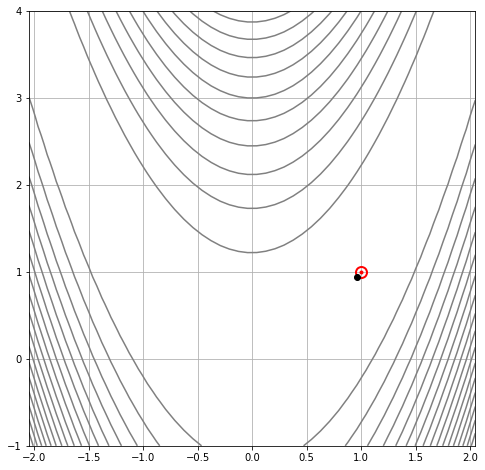

In [5]:
plot_contour(
    fn,
    x_bounds=[(-2.048, 2.048), (-1, 4)],
    minimum=[(1, 1)],
)
plt.gca().plot(
    Z[0][0],
    Z[0][1],
    "o",
    c="k",
)
plt.show()

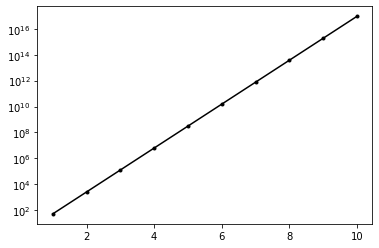

In [6]:
#
# Este método no es viable cuando aumenta la cantidad de
# dimensiones de la función a minimizar.
#
#    puntos_a_evaluar = n_points ** n_dims
#
# El crecimiento es exponencial.
#
n_points = 50
n_dims = np.array(range(1, 11))
fn_evals = np.power(n_points, n_dims)
plt.plot(n_dims, fn_evals, ".-k")
plt.yscale("log")
plt.show()

## Método de Monte Carlo

In [9]:
#
# Consiste en generar un muestreo aleatorio de la región
# factibles y escoger el mejor punto encontrado
#
n_points = 1000

rng = np.random.default_rng(12345)

X = rng.uniform(low=xb[0], high=xb[1], size=n_points)
Y = rng.uniform(low=yb[0], high=yb[1], size=n_points)
Z = np.array([(x, y, fn(np.array([x, y]))) for x, y in zip(X, Y)])
Z_sorted = sorted(Z, key=itemgetter(2))

#
#  punto de mínima encontrado y cantidad de puntos evaluados
#
Z_sorted[0], len(Z_sorted)

(array([0.95231102, 0.88811836, 0.03753524]), 1000)

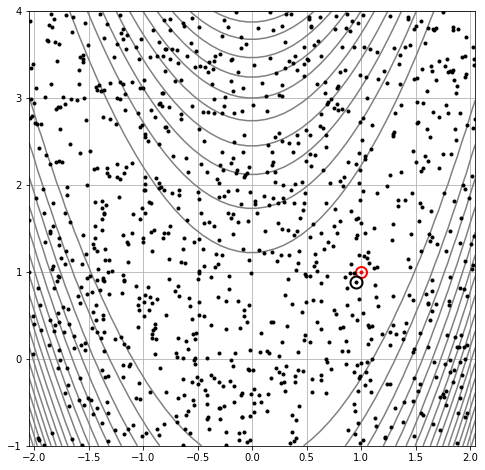

In [14]:
#
# Se grafican los puntos generados aleatoriamente sobre el
# contorno de la función.
#
plot_contour(
    fn,
    x_bounds=[(-2.048, 2.048), (-1, 4)],
    minimum=[(1, 1)],
)
plt.gca().plot(X, Y, ".k")
plt.gca().plot(
    Z_sorted[0][0],
    Z_sorted[0][1],
    "o",
    c="k",
    fillstyle="none",
    markersize=12,
    markeredgewidth=2,    
)
plt.show()

Para analizar el comportamiento resulta más interesante considerar la generación de 10 bloques de 100 elementos aleatorios cada uno.

In [18]:
from generators import RandomUniform

#
# Crea una función que genera soluciones uniformemente
# distribuidas en el hipercubo definido por los límites
# low y high
#
monte_carlo = RandomUniform(
    pop_size=100,
    low=[-2.048, -1.0],
    high=[2.048, 4.0],
    seed = 123456,
)

#
# Genera una muestra aleatoria de 100 soluciones
#
solutions = monte_carlo()

#
# Primeros 5 vectores aleatorios
#
solutions[:5]

[{'x': array([0.55916032, 0.92405832]), 'fn_x': None},
 {'x': array([-1.85366355,  3.7762637 ]), 'fn_x': None},
 {'x': array([1.66318464, 1.28484777]), 'fn_x': None},
 {'x': array([-0.89893488,  2.18074402]), 'fn_x': None},
 {'x': array([1.96899098, 3.06215893]), 'fn_x': None}]

In [19]:
#
# Evaluación de la función objetivo
#
from fnevaluator import FnEvaluator

#
# Crea una instancia del evaluador que permite evaluar la
# función de rosenbrock para cada elemento de la muestra
# de soluciones
#
evaluator = FnEvaluator(fn)

#
# Evalua la muestra aleatoria
#
solutions = evaluator(solutions)

#
# Primeros 5 vectores aleatorios evaluados
#
solutions[:5]

[{'x': array([0.55916032, 0.92405832]), 'fn_x': 37.575098600043574},
 {'x': array([-1.85366355,  3.7762637 ]), 'fn_x': 19.716668139797637},
 {'x': array([1.66318464, 1.28484777]), 'fn_x': 219.87525881237536},
 {'x': array([-0.89893488,  2.18074402]), 'fn_x': 192.0255276165787},
 {'x': array([1.96899098, 3.06215893]), 'fn_x': 67.32339885139984}]

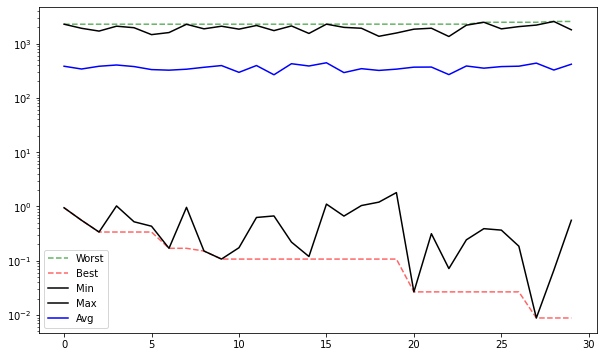

In [20]:
from stats import Statistics

#
# Se instancia un objeto para computar las estadísticas de
# la corrida
#
stats = Statistics()

#
# Se generan 30 poblaciones de 100 elementos cada una
#
for i_run in range(30):
    #
    # Generación de la población
    #
    solutions = monte_carlo()

    #
    # Se evalua la función objetivo
    #
    solutions = evaluator(solutions)

    #
    # Se computan las estadísticas de la población actual
    #
    stats(solutions)

#
# Evolución de las estadísitcas para cada corrida. El
# algoritmo no aprovecha la información obtenida sobre
# la superficie en cada una de las 10 iteraciones. El
# valor promedio de la función objetivo no mejora.
#
stats.plot()

In [21]:
#
# Valor mínimo encontrado en cada una de las 30 corridas.
#
stats.min

[0.9451628228735972,
 0.5555928534856909,
 0.3378027223328357,
 1.0216852537303396,
 0.5217371471704918,
 0.43235643515646494,
 0.1693594482626956,
 0.9620507939517328,
 0.15093156329322785,
 0.10728073976883273,
 0.17369287775829803,
 0.6261920254943957,
 0.6680476689039231,
 0.22037320250709788,
 0.11965595329708716,
 1.103240390522768,
 0.6644356131678282,
 1.0383740141523572,
 1.2003183764698524,
 1.7983413858719155,
 0.02668855092315474,
 0.3147544834213636,
 0.07170081191379087,
 0.24285700496283746,
 0.38955004367747054,
 0.36622628671796303,
 0.18527175406109053,
 0.008825398602853491,
 0.0669003665637732,
 0.5562008619806511]

In [22]:
#
# Mejor valor encontrado en cada una de las 30 corridas.
#
stats.best

[0.9451628228735972,
 0.5555928534856909,
 0.3378027223328357,
 0.3378027223328357,
 0.3378027223328357,
 0.3378027223328357,
 0.1693594482626956,
 0.1693594482626956,
 0.15093156329322785,
 0.10728073976883273,
 0.10728073976883273,
 0.10728073976883273,
 0.10728073976883273,
 0.10728073976883273,
 0.10728073976883273,
 0.10728073976883273,
 0.10728073976883273,
 0.10728073976883273,
 0.10728073976883273,
 0.10728073976883273,
 0.02668855092315474,
 0.02668855092315474,
 0.02668855092315474,
 0.02668855092315474,
 0.02668855092315474,
 0.02668855092315474,
 0.02668855092315474,
 0.008825398602853491,
 0.008825398602853491,
 0.008825398602853491]

## Método del Gradiente

In [23]:
#
# El método del gradiente descendente aprovecha la
# información local que entrega el punto actual para
# generar una aproximación mejor al mínimo.
#
from gd import GradientDescendent

#
# Se crea una instancia del optimizador. Cada llamada
# realiza una sola iteración del método del gradiente
# descendente.
#
optimizer = GradientDescendent(fn=fn, learning_rate=0.0001)

#
# Se crea una instancia del geneador para crear poblaciones
# de una sola solución.
#
monte_carlo = RandomUniform(
    pop_size=1,
    low=[-2.048, -1.0],
    high=[2.048, 4.0],
    seed=123456,
)

#
# Se crea la población de soluciones
#
solutions = monte_carlo()


#
# Se instancia un objeto para computar las estadísticas de
#  la corrida
#
stats = Statistics()

#
# Se realizan NITER iteraciones del algoritmo de gradiente
# descendente
#
NITER = 50

for iter in range(NITER):
    #
    # El único individuo existente tiene indice 0
    #
    solutions = optimizer(solutions)

    #
    # Se computan las estadísticas de la población actual
    #
    stats(solutions)

solutions[0].x, solutions[0].fn_x

(array([0.8376432 , 0.72117049]), 0.06447978322518463)

In [24]:
#
# Valor mínimo encontrado en cada iteración
#
stats.min

[34.23892740663191,
 31.117673882920926,
 28.207193218239517,
 25.50241282237967,
 22.997371482130475,
 20.685282406118418,
 18.55861689011423,
 16.60920465740078,
 14.828346493072353,
 13.206934608795223,
 11.735576237206786,
 10.40471623695048,
 9.204754951027498,
 8.126158154842784,
 7.159556604724383,
 6.295833402810923,
 5.526198085254375,
 4.84224698086851,
 4.23600994939766,
 3.6999840751200104,
 3.2271552545148374,
 2.811008876266374,
 2.445530954381593,
 2.1252011516404563,
 1.8449791347029065,
 1.6002856488681039,
 1.3869796045141778,
 1.2013323423823468,
 1.0400001031754946,
 0.8999955784764418,
 0.7786592727051848,
 0.6736312656461868,
 0.5828238360648615,
 0.5043952915988765,
 0.4367252496686844,
 0.3783915288169947,
 0.32814873913768866,
 0.28490860326886813,
 0.24772199446950888,
 0.2157626440866744,
 0.18831244572192044,
 0.16474826613638582,
 0.14453016200862967,
 0.12719089582428267,
 0.112326642329336,
 0.09958877816973098,
 0.08867665076893212,
 0.07933122750113727,

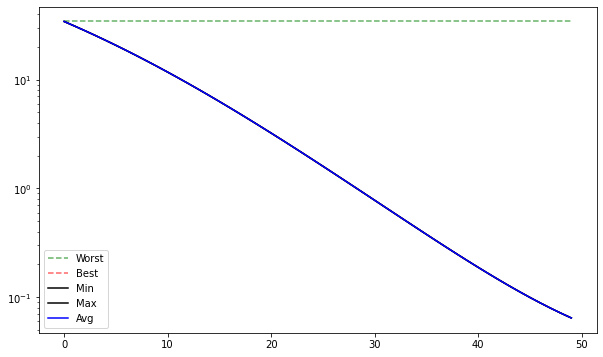

In [25]:
stats.plot()

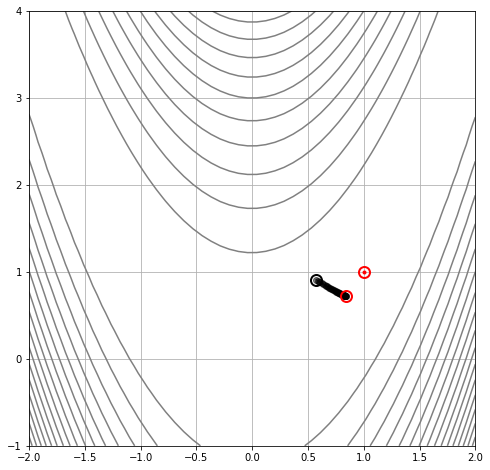

In [26]:
#
# Trayectoria del punto inicial al punto final
#
from plots import plot_trayectory

plot_trayectory(stats, fn, x_bounds=[(-2, 2), (-1, 4)], minimum=[(1, 1)])

## Método del gradiente descendente con reinicio

In [27]:
#
# El resultado del método es dependiente del punto de
# arranque por lo que se suele reiniciar la optimización
# usando puntos de arranque aleatorios
#

# Crea una instancia del optimizador
optimizer = GradientDescendent(fn=fn, learning_rate=0.0001)

# Estadísticas de las corridas
stats = Statistics()

# Generador del punto aleatorio
monte_carlo = RandomUniform(
    pop_size=1,
    low=[-2.048, -1.0],
    high=[2.048, 4.0],
    seed=123456,
)

# Número de reinicios
NRESTARTS = 10


# Número de iteraciones para cada reinicio
NITER = 50

for cycle in range(NRESTARTS):

    #  reinicio
    solutions = monte_carlo()

    for iter in range(NITER):

        # El único individuo existente tiene indice 0
        solutions = optimizer(solutions)

        # Se computan las estadísticas de la población actual
        stats(solutions)


stats.x_opt, stats.fn_opt

(array([-1.67664313,  0.32788264]), 623.8172538346686)

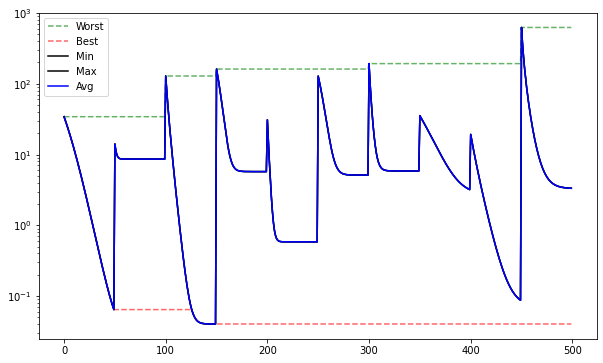

In [28]:
stats.plot()

## Búsqueda de un buen punto de inicio

In [30]:
#
# En superficies dificiles, malos puntos de inicio suelen
# llevar a malas soluciones finales, por lo que se puede
# usar una técnica como Monte Carlo para encontrar un buen
# punto de arranque
#

# Crea una instancia del optimizador
optimizer = GradientDescendent(fn=fn, learning_rate=0.0001)

# Estadísticas de las corridas
stats = Statistics()

# Cantidad de soluciones simultánteas
POPSIZE = 10

# Generador del punto aleatorio
monte_carlo = RandomUniform(
    pop_size=POPSIZE,
    low=[-2.048, -1.0],
    high=[2.048, 4.0],
    seed=123456,
)

# Número de iteraciones
NITER = 50

# Genera una población inicial de soluciones
solutions = optimizer(solutions)
stats(solutions)

#
# Crea una instancia del seleccionador
#
from selection import SelectionBest

selectionBest = SelectionBest(k=1)
solutions = selectionBest(solutions)

for iter in range(NITER):
    solutions = optimizer(solutions)
    stats(solutions)

stats.x_opt, stats.fn_opt

(array([-0.82142547,  0.66663132]), 3.3241654999950074)

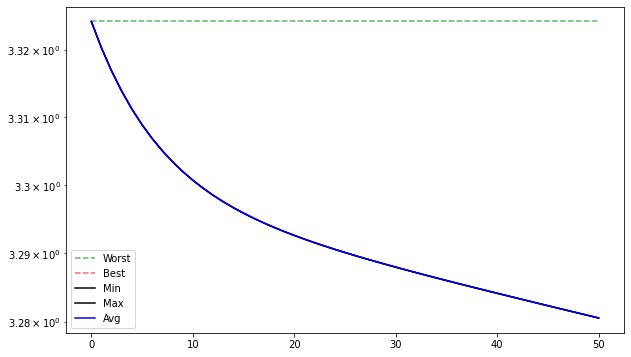

In [31]:
stats.plot()

## Genetización del método del gradiente descendente

In [32]:
#
# Se refiere al hecho de tener una población de soluciones
# y en cada ciclo, cada una realiza un ciclo del gradiente
#  descendente (o cualquier otra técnica de búsqueda local)
#

# Crea una instancia del optimizador
optimizer = GradientDescendent(fn=fn, learning_rate=0.0001)

# Estadísticas de las corridas
stats = Statistics()

# Cantidad de soluciones simultánteas
POPSIZE = 10

# Generador del punto aleatorio
monte_carlo = RandomUniform(
    pop_size=POPSIZE,
    low=[-2.048, -1.0],
    high=[2.048, 4.0],
    seed=123456,
)

# Número de iteraciones
NITER = 50

#  Generación de las soluciones iniciales
solutions = monte_carlo()

for iter in range(NITER):

    solutions = optimizer(solutions)
    stats(solutions)


stats.x_opt, stats.fn_opt

(array([-1.87844778,  3.7694498 ]), 14.087959241629456)

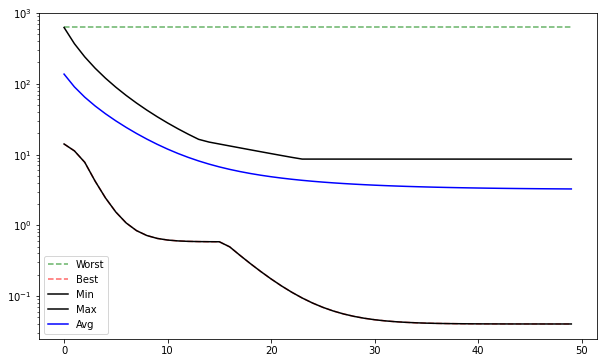

In [33]:
stats.plot()

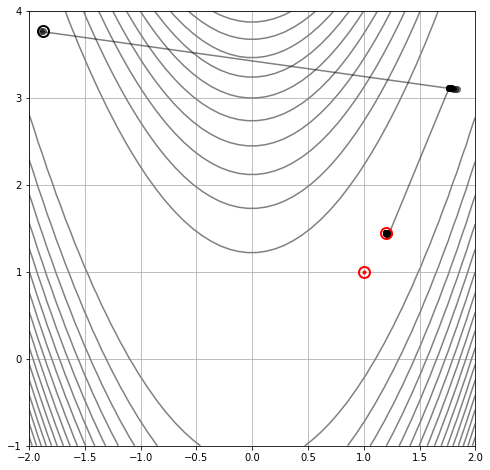

In [34]:
plot_trayectory(stats, fn, x_bounds=[(-2, 2), (-1, 4)], minimum=[(1, 1)])